In [1]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

In [2]:
data_dir='../input/jovian-pytorch-z2g/Human protein atlas'
print(os.listdir(data_dir))

['train.csv', 'train', 'test']


In [3]:
train_dir=data_dir +'/train'
test_dir=data_dir +'/test'
train_csv_dir=data_dir +'/train.csv'
test_csv_dir= '../input/jovian-pytorch-z2g/submission.csv'

In [4]:
data_df = pd.read_csv(train_csv_dir)
data_df.head()

,Image,Label
0,19567,9
1,29993,6 4
2,17186,1 4
3,29600,6 2
4,701,3 4


In [5]:
!head "{train_csv_dir}"

Image,Label
19567,9
29993,6 4
17186,1 4
29600,6 2
701,3 4
26562,9
1080,4
27886,4
30721,6


In [6]:
!head "{test_csv_dir}"

Image,Label
24117,0
15322,0
14546,0
8079,0
13192,0
25927,0
3372,0
21781,0
2847,0


In [7]:
# Let's also put the textual labels in a dictionary for later use.
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

In [8]:
#This fnc is used to convert labels into vector of length 10 with values 0 ,1 
def encode_label(label):
    target=torch.zeros(10)
    for i in str(label).split():
        target[int(i)]=1
    return target

In [9]:
encode_label('2 3')

tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 0.])

In [74]:
#This fnc is used to decode values(names of proteins) from encoded labels
def decode_target(target,text_labels=False):
    decode=[]
    for i in range(len(target)):
        if target[i]>0.4:
            if text_labels:
                decode.append(labels[i]+'('+str(i)+')')
            else:
                decode.append(str(i))
    return ' '.join(decode)

In [75]:
decode_target(torch.tensor([0.2, 0.3, 0.43, 0.58, 1, 0.56, 0, 0, 0, 0.]))

'2 3 4 5'

In [54]:
decode_target(torch.tensor([0.2, 0.3, 0.43, 0.58, 1, 0.56, 0, 0, 0, 0.]),text_labels=True)

'Golgi apparatus(3) Nucleoplasm(4) Nucleoli fibrillar center(5)'

Now our next task is to bulid our training set by combining training images and train.csv file to create an appropriate set for our model

For this purpose we extend Dataset class from pytorch,We need to define the __ len__ and __getitem__ methods to create a dataset. We'll also provide the option of adding transforms into the constructor.

In [13]:
class HumanProteinDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

In [14]:
import torchvision.transforms as T

In [ ]:
#used to calculate mean and std of channels
nimages = 0
mean = 0.0
var = 0.0
for i_batch, batch_target in enumerate(train_loader):
    batch = batch_target[0]
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute mean and std here
    mean += batch.mean(2).sum(0) 
    var += batch.var(2).sum(0)

mean /= nimages
var /= nimages
std = torch.sqrt(var)

print(mean)
print(std)

In [16]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #source pytorch documentation

train_tfms = T.Compose([T.Resize(224),
                        T.CenterCrop(224),
                        T.RandomCrop(224, padding=8, padding_mode='reflect'),
                        T.RandomHorizontalFlip(), 
                        T.RandomRotation(10),
                        T.ToTensor(),
                        T.Normalize(*imagenet_stats)])

valid_tfms = T.Compose([T.Resize(224), 
                        T.CenterCrop(224),
                        T.ToTensor(),
                        T.Normalize(*imagenet_stats)])


In [17]:
np.random.seed(42)
msk = np.random.rand(len(data_df)) < 0.9

train_df = data_df[msk].reset_index()
val_df = data_df[~msk].reset_index()

In [18]:
train_ds = HumanProteinDataset(train_df, train_dir, transform=train_tfms)
val_ds = HumanProteinDataset(val_df, train_dir, transform=valid_tfms)
len(train_ds), len(val_ds)

(17335, 1901)

In [19]:
img,label=train_ds[0]
img.shape,label

(torch.Size([3, 224, 224]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

Nuclear speckles(9)


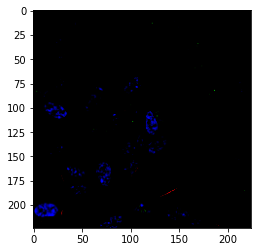

In [20]:
plt.imshow(img.permute(1,2,0))
print(decode_target(label,text_labels=True))

9


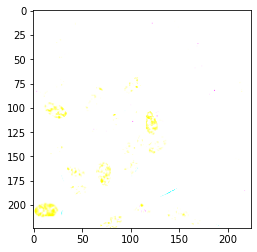

In [21]:
#To produce inverted image
plt.imshow(1-img.permute(1,2,0))
print(decode_target(label))

# Divide dataset into training and  validation set 

In [22]:
#divide data into batches
batch_size=64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)


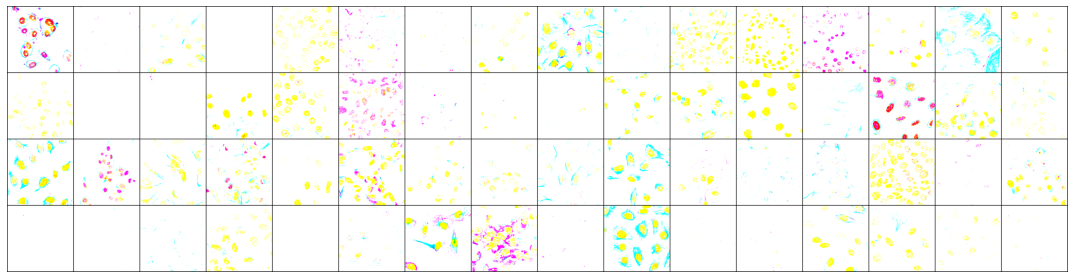

In [23]:
for img,yb in train_loader:
    plt.figure(figsize=(19,8))
    plt.imshow(make_grid(1-img,nrow=16).permute(1,2,0))
    plt.axis('off')
    break

In [24]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [25]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}],last_lrs{:.5f},train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch,result['lrs'][-1],result['train_loss'], result['val_loss'], result['val_score']))

In [ ]:
#creating CNN Model
def conv_block(in_channels,out_channels,pool=False):
    layers=[nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ProteinCnnModel(MultilabelImageClassificationBase):
    def __init__(self,in_channels,num_classes):
        super().__init__()
        self.conv1=conv_block(in_channels,64)  
        self.conv2=conv_block(64,64)  
        self.conv3=conv_block(64,64)
        self.res1=nn.Sequential(conv_block(64,64),conv_block(64,64))
        
        self.conv4=conv_block(64,128) 
        self.conv5=conv_block(128,128) 
        self.conv6=conv_block(128,128)
        self.res2=nn.Sequential(conv_block(128,128),conv_block(128,128))
        
        self.conv7=conv_block(128,256) 
        self.conv8=conv_block(256,256) 
        self.conv9=conv_block(256,256)
        self.res3=nn.Sequential(conv_block(256,256),conv_block(256,256))
        
        self.conv10=conv_block(256,512) 
        self.conv11=conv_block(512,512)
        self.conv12=conv_block(512,512)
        self.res4=nn.Sequential(conv_block(512,512),conv_block(512,512))
                
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d(output_size=(1,1)),
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out=self.conv1(xb)
        out=self.conv2(out)
        out=self.conv3(out)
        out=self.res1(out) + out
        out=self.conv4(out)
        out=self.conv5(out)
        out=self.conv6(out)
        out=self.res2(out) + out
        out=self.conv7(out)
        out=self.conv8(out)
        out=self.conv9(out)
        out=self.res3(out) + out
        out=self.conv10(out)
        out=self.conv11(out)
        out=self.conv12(out)
        out=self.res4(out) + out
        out=self.classifier(out)
        
        return torch.sigmoid(out)


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs,max_lr, model, train_loader, val_loader,weight_decay=0,opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(),max_lr,weight_decay=weight_decay)
    
    # Set up cutom optimizer with weight decay
    scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs=[]
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            #gradient_clipping
            #if grad_clip:
            #   nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Using Transfer Learning

In [26]:
#Using Transfer Learning
class ProteinResnet18(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [27]:
model=ProteinResnet18()
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


ProteinResnet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

Moving all values and model to GPU

In [28]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [29]:
device = get_default_device()
device

device(type='cuda')

In [30]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
model=to_device(model, device)

In [31]:
from tqdm.notebook import tqdm

In [36]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs,max_lr, model, train_loader, val_loader,weight_decay=0,opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(),max_lr,weight_decay=weight_decay)
    
    # Set up cutom optimizer with weight decay
    scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs=[]
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            #gradient_clipping
            #if grad_clip:
            #   nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [33]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 0.5482096076011658, 'val_score': 0.22562190890312195}]

In [37]:
model.freeze()

In [38]:
epochs = 8
max_lr = 0.001
weight_decay = 2e-4
#grad_clip=0.1
opt_func = torch.optim.Adam

In [39]:
%%time
history += fit(epochs,max_lr, model, train_loader, val_loader,weight_decay=weight_decay,opt_func=opt_func)



Epoch [0],last_lrs0.00039,train_loss: 0.3396, val_loss: 0.3185, val_score: 0.4653



Epoch [1],last_lrs0.00094,train_loss: 0.2723, val_loss: 0.2960, val_score: 0.5635



Epoch [2],last_lrs0.00097,train_loss: 0.2582, val_loss: 0.2772, val_score: 0.5907



Epoch [3],last_lrs0.00081,train_loss: 0.2459, val_loss: 0.2703, val_score: 0.5659



Epoch [4],last_lrs0.00056,train_loss: 0.2328, val_loss: 0.2441, val_score: 0.6268



Epoch [5],last_lrs0.00028,train_loss: 0.2181, val_loss: 0.2127, val_score: 0.6848



Epoch [6],last_lrs0.00008,train_loss: 0.2007, val_loss: 0.1980, val_score: 0.7202



Epoch [7],last_lrs0.00000,train_loss: 0.1859, val_loss: 0.1936, val_score: 0.7388
CPU times: user 1min 31s, sys: 29.9 s, total: 2min 1s
Wall time: 26min 4s


In [66]:
%%time
history += fit(epochs,max_lr, model, train_loader, val_loader,weight_decay=weight_decay,opt_func=opt_func)


Epoch [0],last_lrs0.00039,train_loss: 0.1922, val_loss: 0.2261, val_score: 0.6886



Epoch [1],last_lrs0.00094,train_loss: 0.2212, val_loss: 0.2767, val_score: 0.6044



Epoch [2],last_lrs0.00097,train_loss: 0.2312, val_loss: 0.2408, val_score: 0.6276



Epoch [3],last_lrs0.00081,train_loss: 0.2243, val_loss: 0.2558, val_score: 0.6226



Epoch [4],last_lrs0.00056,train_loss: 0.2156, val_loss: 0.2285, val_score: 0.6586



Epoch [5],last_lrs0.00028,train_loss: 0.2024, val_loss: 0.2074, val_score: 0.7000



Epoch [6],last_lrs0.00008,train_loss: 0.1894, val_loss: 0.1934, val_score: 0.7315



Epoch [7],last_lrs0.00000,train_loss: 0.1789, val_loss: 0.1898, val_score: 0.7395
CPU times: user 1min 31s, sys: 30.2 s, total: 2min 1s
Wall time: 26min 26s


In [67]:
model.unfreeze()

In [68]:
%%time
history += fit(epochs,max_lr, model, train_loader, val_loader,weight_decay=weight_decay,opt_func=opt_func)


Epoch [0],last_lrs0.00039,train_loss: 0.1827, val_loss: 0.2212, val_score: 0.6722



Epoch [1],last_lrs0.00094,train_loss: 0.2051, val_loss: 0.2689, val_score: 0.5868



Epoch [2],last_lrs0.00097,train_loss: 0.2142, val_loss: 0.2461, val_score: 0.6061



Epoch [3],last_lrs0.00081,train_loss: 0.2121, val_loss: 0.2479, val_score: 0.6442



Epoch [4],last_lrs0.00056,train_loss: 0.2043, val_loss: 0.2365, val_score: 0.6448



Epoch [5],last_lrs0.00028,train_loss: 0.1941, val_loss: 0.2039, val_score: 0.7037



Epoch [6],last_lrs0.00008,train_loss: 0.1814, val_loss: 0.1894, val_score: 0.7454



Epoch [7],last_lrs0.00000,train_loss: 0.1727, val_loss: 0.1860, val_score: 0.7467
CPU times: user 1min 29s, sys: 29.8 s, total: 1min 59s
Wall time: 26min 7s


In [72]:
epochs = 4
max_lr = 0.0001
weight_decay = 2e-5
#grad_clip=0.1
opt_func = torch.optim.Adam

In [73]:
%%time
history += fit(epochs,max_lr, model, train_loader, val_loader,weight_decay=weight_decay,opt_func=opt_func)


Epoch [0],last_lrs0.00009,train_loss: 0.1708, val_loss: 0.1877, val_score: 0.7484



Epoch [1],last_lrs0.00008,train_loss: 0.1718, val_loss: 0.1921, val_score: 0.7360



Epoch [2],last_lrs0.00003,train_loss: 0.1683, val_loss: 0.1844, val_score: 0.7529



Epoch [3],last_lrs0.00000,train_loss: 0.1645, val_loss: 0.1841, val_score: 0.7530
CPU times: user 45.1 s, sys: 15 s, total: 1min
Wall time: 13min


In [83]:
%%time
history += fit(epochs,max_lr, model, train_loader, val_loader,weight_decay=weight_decay,opt_func=opt_func)


Epoch [0],last_lrs0.00009,train_loss: 0.1650, val_loss: 0.1858, val_score: 0.7515



Epoch [1],last_lrs0.00008,train_loss: 0.1660, val_loss: 0.1879, val_score: 0.7490



Epoch [2],last_lrs0.00003,train_loss: 0.1626, val_loss: 0.1840, val_score: 0.7586



Epoch [3],last_lrs0.00000,train_loss: 0.1598, val_loss: 0.1825, val_score: 0.7617
CPU times: user 44.2 s, sys: 13.9 s, total: 58.1 s
Wall time: 12min 59s


In [40]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

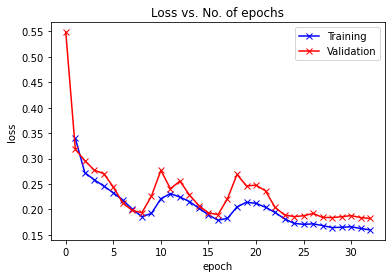

In [84]:
plot_losses(history)

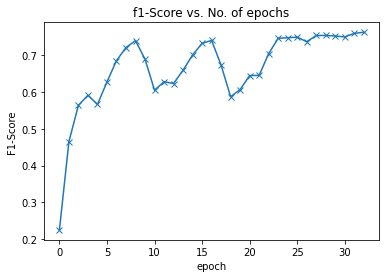

In [85]:
accuracies = [x['val_score'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('F1-Score')
plt.title('f1-Score vs. No. of epochs');

In [57]:
def predict(image):
    xb=image.unsqueeze(0)
    xb=to_device(xb,device)
    preds=model(xb)
    prediction=preds[0]
    print('prediction',prediction)
    plt.imshow(image.permute(1,2,0))
    print(decode_target(prediction,text_labels=True))

In [44]:
test_df = pd.read_csv(test_csv_dir)
test_dataset = HumanProteinDataset(test_df, test_dir, transform=valid_tfms)

prediction tensor([6.1025e-04, 1.7950e-02, 1.0595e-01, 4.6566e-04, 9.8289e-01, 1.0476e-02,
        9.4043e-01, 1.9673e-03, 1.8643e-03, 4.3015e-04], device='cuda:0',
       grad_fn=<SelectBackward>)
Nucleoplasm(4) Cytosol(6)


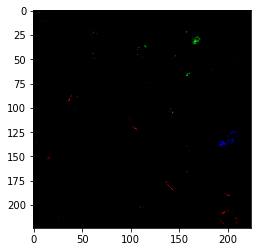

In [86]:
predict(test_dataset[100][0])

prediction tensor([9.2703e-01, 4.2891e-03, 1.0467e-03, 1.4318e-01, 5.0819e-02, 8.2999e-04,
        2.3920e-02, 3.7619e-03, 6.1691e-03, 1.4606e-03], device='cuda:0',
       grad_fn=<SelectBackward>)
Mitochondria(0)


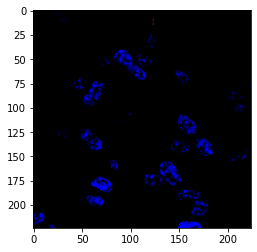

In [87]:
predict(test_dataset[74][0])

In [59]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2, num_workers=3, pin_memory=True), device)

In [88]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

In [89]:
test_preds = predict_dl(test_loader, model)

In [90]:
test_csv = '../input/jovian-pytorch-z2g/submission.csv' 
submission_df = pd.read_csv(test_csv)
submission_df.Label = test_preds
submission_df['Label']

0         4 9
1           4
2           6
3           6
4         3 4
        ...  
8238        0
8239    2 4 7
8240      0 6
8241      5 6
8242        4
Name: Label, Length: 8243, dtype: object

In [91]:
sub_name = 'submission_cnn_new3.csv'
submission_df.to_csv(sub_name, index=False)